<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Logs-and-Models" data-toc-modified-id="Load-Logs-and-Models-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Logs and Models</a></span></li><li><span><a href="#Best-Heuristic" data-toc-modified-id="Best-Heuristic-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Best Heuristic</a></span></li><li><span><a href="#Other-Heuristics" data-toc-modified-id="Other-Heuristics-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Other Heuristics</a></span></li><li><span><a href="#Anomaly-Types" data-toc-modified-id="Anomaly-Types-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Anomaly Types</a></span></li></ul></div>

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#export
from dapnn.imports import *
from dapnn.data_processing import *

from dapnn.anomaly import * 
from dapnn.heuristics import * 

import seaborn as sns
sns.set_theme(style="darkgrid")

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Load Logs and Models

In [ ]:
res_df = pd.read_csv('results/binet_logs_0.98_25.csv',dtype={'log_name':str})
#res_df =res_df[res_df['log_name'].str.contains('bpic')] # drop bpic logs


In [ ]:
len(res_df)

40

In [ ]:
logs = res_df['log_name'].tolist()

In [ ]:
learner_path=f'models/binet_logs/'

In [ ]:
def load_pred_model(learner_path,train_log_path,log_name,cols=['activity']):
    p = f'{learner_path}/{log_name}_vocab.p'
    with open(p, 'rb') as fp:
        categorify = pickle.load(fp)
    log = import_log(train_log_path)
    o = process_test(log,categorify,cols)
    dls=o.get_dls()
    loss=partial(multi_loss_sum,o)
    emb_szs = get_emb_sz(o)
    m=MultivariateModel(emb_szs)
    learn=Learner(dls, m, path=learner_path, model_dir='.', loss_func=loss, metrics=get_metrics(o))
    learn.load(log_name,with_opt=False)
    m=learn.model.cuda()
    return m, categorify
#export
def multivariate_anomaly_score(res,o,idx,cols):
    score_df=pd.DataFrame()

    for cidx,_ in enumerate(cols):
        sm = nn.Softmax(dim=1)
        p = sm(res[cidx].cpu())
        pred = p.max(1)[0]
        y = o.items[cols[cidx]].iloc[idx].values

        truth=p[list(range(len(y))),y]
        score = ((pred - truth) / pred).tolist()
        score_df[cols[cidx]] = score
    score_df['trace_id']=o.items['trace_id'].iloc[idx].values
    return score_df


In [ ]:
def get_score_df(log_name):
    fn=f'data/csv/binet_logs/{log_name}.csv.gz'
    cols= get_attr(attr_dict,fn)
    training_log_path=f'data/csv/binet_logs/{log_name}.csv.gz'
    m2, categorify = load_pred_model(learner_path,training_log_path,log_name,cols=cols)
    log = import_log(fn,cols)
    o = process_test(log,categorify,cols)
    res,idx=predict_next_step(o,m2)
    score_df=multivariate_anomaly_score(res,o,idx,cols)
    return score_df,cols,o

In [ ]:
log_name= 'bpic15-0.3-4'
score_df,cols,o = get_score_df(log_name)


In [ ]:
[v for v in cols if v in all_cols]

In [ ]:
max_error_cases = score_df.groupby('trace_id').max()
y_true =o.items.groupby(o.items.index)['anomaly'].last().to_numpy() != 'normal'


In [ ]:
all_cols = np.unique([i for j in attr_dict.values() for i in j ])

##  Best Heuristic

In [ ]:
all_cols =['activity', 'user', 'day', 'country', 'company','org:resource',]

In [ ]:
from bayes_opt import BayesianOptimization
def optimize(**settings):
    y_pred =(np.array([(max_error_cases[c]>settings[c]).tolist() for c in cols]).max(axis=0))   
    return (f1_score(y_pred,y_true))

# Bounded region of parameter space
pbounds = {c:(0.9,1.0) for c in cols}


In [ ]:

optimizer = BayesianOptimization(
    f=optimize,
    pbounds=pbounds,
    verbose=0,
    random_state=1,
)
optimizer.maximize(init_points=20, n_iter=200)

In [ ]:
optimizer.max

In [ ]:
# Only run this if you want to recreate the best_th_df, takes arround 3h
res = []
for log_name in progress_bar(logs):
    score_df,cols,o = get_score_df(log_name)
    max_error_cases = score_df.groupby('trace_id').max()
    y_true =o.items.groupby(o.items.index)['anomaly'].last().to_numpy() != 'normal'
    pbounds = {c:(0.8,1.0) for c in cols}

    optimizer = BayesianOptimization(
        f=optimize,
        pbounds=pbounds,
        verbose=0,
        random_state=1,
    )
    optimizer.maximize(init_points=20, n_iter=500)
    res.append([log_name,optimizer.max['target']]+
               [optimizer.max['params'][c] if c in cols else 0.0 for c in all_cols ])


,log_name,best F1 Score,activity,user,day,country,company,org:resource
0,bpic15-0.3-4,0.505628,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
1,large-0.3-4,0.969201,0.926509,0.993697,0.991158,0.996668,0.998505,0.000000
2,small-0.3-4,0.996392,0.827836,0.990407,0.996365,0.978193,0.984546,0.000000
3,bpic13-0.3-3,0.576037,0.828376,0.000000,0.000000,0.000000,0.000000,1.000000
4,medium-0.3-3,0.983084,0.853375,0.994926,0.989199,0.996987,0.000000,0.000000
5,medium-0.3-1,0.986074,0.922664,0.979162,0.000000,0.000000,0.000000,0.000000
6,bpic17-0.3-1,0.748115,0.988349,0.000000,0.000000,0.000000,0.000000,0.999921
7,wide-0.3-3,0.982225,0.967521,0.991711,0.991390,0.997332,0.000000,0.000000
8,large-0.3-2,0.988482,0.943651,0.993239,0.994222,0.000000,0.000000,0.000000
9,bpic17-0.3-2,0.857663,0.893300,0.000000,0.000000,0.000000,0.000000,0.998656


In [ ]:
best_th_df.to_csv('results/binet_naive_bayes_best_ths_all_ds_all_cols.csv',index=False)

In [ ]:
best_th_df = pd.DataFrame(res,columns=['log_name','best F1 Score',*all_cols])

In [ ]:
best_th_df =pd.read_csv('results/binet_naive_bayes_best_ths.csv')
best_th_df

##  Other Heuristics

In [ ]:
def multi_attr_f1_score(y_true,max_error_cases,ths):
    y_pred =(np.array([(max_error_cases[c]>ths[c]).tolist() for c in cols]).max(axis=0))   
    return f1_score(y_pred,y_true)


In [ ]:
def threshold_anomaly_ratio_df(max_error_cases,min_th= 0.0):
    res = []
    for col in cols:
        ths = max_error_cases[col].unique()
        ths = ths[ths >min_th]
        r = np.array([sum(max_error_cases[col] >th) for th in ths])/len(max_error_cases)
        res+=zip(ths,r,[col]*len(ths))
    return pd.DataFrame(res,columns=['Th','Anomaly Ratio','Col']) 

def threshold_anomaly_ratio_df_fixed(max_error_cases):
    ths =np.arange(100)*0.001+0.9
    res=[]
    for col in cols:
        r = np.array([sum(max_error_cases[col] >th) for th in ths])/len(max_error_cases)
        res+=zip(ths,r,[col]*len(ths))
    return pd.DataFrame(res,columns=['Th','Anomaly Ratio','Col']) 


In [ ]:
heuristics = [partial(get_ratio_th,0.5),elbow_heuristic,
              partial(get_fixed_heuristic,0.98),get_lowest_plateau_heuristic]
heuristic_names = ['r_0.5','e_down','e_up','fix','lp_min','lp_mean','lp_max']

In [ ]:
log_name='paper-0.3-1'

score_df,cols,o = get_score_df(log_name)
max_error_cases = score_df.groupby('trace_id').max()
y_true =o.items.groupby(o.items.index)['anomaly'].last().to_numpy() != 'normal'
df =threshold_anomaly_ratio_df_fixed(max_error_cases)
multi_attr_f1_score(y_true,max_error_cases,{'activity':0.945,'user':0.984})

In [ ]:
get_lowest_plateau_heuristic(df[df['Col']=='user'])

In [ ]:
test = df[df['Col']=='activity'].copy()
test.index = test['Th']

In [ ]:
get_lowest_plateau_heuristic(test)

In [ ]:
log_name='paper-0.3-1'
score_df,cols,o = get_score_df(log_name)
max_error_cases = score_df.groupby('trace_id').max()
y_true =o.items.groupby(o.items.index)['anomaly'].last().to_numpy() != 'normal'
df =threshold_anomaly_ratio_df_fixed(max_error_cases)
#df =threshold_anomaly_ratio_df(max_error_cases)

h_ths = {col:[i for j in [[k.Th for k in listify(h(df[df['Col']==col]))] for h in heuristics] for i in j] for col in cols}
h_ths_df = pd.DataFrame(h_ths,index=heuristic_names).transpose()
h_ths_df['Log'] = log_name
h_ths_df

In [ ]:
f1_scores={h:multi_attr_f1_score(y_true,max_error_cases,h_ths_df[h]) for h in heuristic_names}
f1_scores

In [ ]:
logs = res_df['log_name'].tolist()
res = []
res_ths = []
for log_name in progress_bar(logs):
    score_df,cols,o = get_score_df(log_name)
    max_error_cases = score_df.groupby('trace_id').max()
    y_true =o.items.groupby(o.items.index)['anomaly'].last().to_numpy() != 'normal'
    df =threshold_anomaly_ratio_df_fixed(max_error_cases)
    #df =threshold_anomaly_ratio_df(max_error_cases)
    h_ths = {col:[i for j in [[k.Th for k in listify(h(df[df['Col']==col]))] for h in heuristics] for i in j] for col in cols}
    h_ths_df = pd.DataFrame(h_ths,index=heuristic_names).transpose()
    h_ths_df['Log'] = log_name
    res_ths+=h_ths_df.values.tolist()

    f1_scores={h:multi_attr_f1_score(y_true,max_error_cases,h_ths_df[h]) for h in heuristic_names}
    f1_scores['Log']= log_name
    res.append(f1_scores)
heuristic_th_df = pd.DataFrame(res)
heuristic_th_df

,r_0.5,e_down,e_up,fix,lp_min,lp_mean,lp_max,Log
0,0.485050,0.459237,0.450663,0.451471,0.476636,0.476636,0.476636,bpic15-0.3-4
1,0.683498,0.763664,0.756633,0.683498,0.880332,0.880593,0.882161,large-0.3-4
2,0.714419,0.876437,0.935712,0.714419,0.973667,0.973329,0.973329,small-0.3-4
3,0.392010,0.385787,0.381643,0.376168,0.438849,0.438849,0.438849,bpic13-0.3-3
4,0.748778,0.769992,0.790098,0.748778,0.888070,0.888070,0.888070,medium-0.3-3
5,0.904010,0.888112,0.919086,0.904010,0.940514,0.940514,0.940514,medium-0.3-1
6,0.544200,0.465739,0.521230,0.459481,0.462072,0.462072,0.462072,bpic17-0.3-1
7,0.758586,0.901408,0.869916,0.758586,0.920241,0.919879,0.919826,wide-0.3-3
8,0.798272,0.918851,0.855229,0.798272,0.981208,0.981208,0.981208,large-0.3-2
9,0.697758,0.662808,0.856978,0.669991,0.675735,0.676807,0.677883,bpic17-0.3-2


In [ ]:
heuristic_th_df.describe()

,r_0.5,e_down,e_up,fix,lp_min,lp_mean,lp_max
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,0.718017,0.761445,0.768559,0.709594,0.813980,0.814048,0.814171
std,0.151623,0.186201,0.182545,0.162586,0.199916,0.199901,0.199913
min,0.392010,0.385787,0.381643,0.376168,0.438849,0.438849,0.438849
25%,0.643203,0.655872,0.681495,0.632708,0.709139,0.709407,0.709676
50%,0.746711,0.819550,0.841196,0.746711,0.910727,0.911719,0.912715
75%,0.847608,0.903009,0.896592,0.847608,0.967288,0.967288,0.967288
max,0.915328,0.990378,0.997303,0.915328,0.995546,0.995546,0.995546


In [ ]:
heuristic_th_df['best']=best_th_df['best F1 Score']

In [ ]:
ds=['BPIC12','BPIC13','BPIC15','BPIC17','Paper','P2P','Small','Medium','Large','Huge','Gigantic','Wide']

df =pd.DataFrame([heuristic_th_df[heuristic_th_df['Log'].str.contains(i.lower())].mean() for i in ds],index = ds)
res_binet_df = df.copy().T
res_binet_df

,BPIC12,BPIC13,BPIC15,BPIC17,Paper,P2P,Small,Medium,Large,Huge,Gigantic,Wide,Mean
fix,0.636067,0.424830,0.458533,0.564736,0.898222,0.842127,0.847290,0.788853,0.743798,0.776281,0.734834,0.805031,0.710050
r_0.5,0.657519,0.442616,0.484107,0.620979,0.898222,0.842127,0.847290,0.788853,0.743798,0.776281,0.740269,0.805031,0.720591
e_down,0.656447,0.448193,0.464921,0.564274,0.964623,0.931890,0.944743,0.823694,0.816543,0.839982,0.766187,0.886711,0.759017
e_up,0.687621,0.446165,0.461019,0.689104,0.893473,0.852231,0.930909,0.858605,0.780066,0.880497,0.829116,0.903445,0.767687
lp_min,0.720274,0.472571,0.474588,0.568904,0.995546,0.972961,0.972772,0.898859,0.927223,0.938850,0.813354,0.954714,0.809218
lp_mean,0.720274,0.472571,0.474588,0.569440,0.995546,0.972961,0.972687,0.898859,0.927288,0.939257,0.813465,0.954623,0.809297
lp_max,0.720274,0.472571,0.474720,0.569978,0.995546,0.972874,0.972687,0.898859,0.928159,0.939755,0.812991,0.954610,0.809419
best,0.726486,0.617670,0.500609,0.802889,0.999659,0.992912,0.995352,0.979680,0.982087,0.969059,0.963616,0.986966,0.876415


In [ ]:
binet_paper =pd.read_csv('data/binet_classification_paper_results.csv',index_col='ad')
binet_paper= binet_paper[binet_paper.columns[:-1]]
binet_paper

,BPIC12,BPIC13,BPIC15,BPIC17,Gigantic,Huge,Large,Medium,P2P,Paper,Small,Wide
ad,,,,,,,,,,,,
BINetv1,0.620944,0.398025,0.345685,0.468883,0.711138,0.713072,0.713074,0.734423,0.767615,0.739184,0.772470,0.760635
BINetv2,0.606927,0.396996,0.375067,0.430140,0.679595,0.703973,0.710234,0.719155,0.767929,0.756928,0.774670,0.733343
BINetv3,0.664307,0.445716,0.362319,0.488593,0.662312,0.692879,0.692470,0.708821,0.769265,0.790624,0.762479,0.738014
DAE,0.595470,0.206788,0.000000,0.295293,0.627368,0.703465,0.712646,0.708075,0.707719,0.463016,0.715753,0.697157
Likelihood,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Likelihood+,0.624890,0.445332,0.329043,0.398566,0.665235,0.676236,0.622254,0.654382,0.610554,0.656008,0.688263,0.637159
Naive,0.550801,0.208840,0.172457,0.313211,0.339600,0.403836,0.410308,0.387077,0.478745,0.500000,0.490269,0.437958
Naive+,0.550801,0.208840,0.173097,0.275905,0.383237,0.453975,0.490268,0.439200,0.479733,0.500000,0.488315,0.469081
OC-SVM,0.545289,0.243008,0.255417,0.351496,0.290641,0.227865,0.236562,0.288863,0.270747,0.485720,0.247770,0.306014


In [ ]:
res_f1 = pd.concat([binet_paper,res_binet_df])
res_f1['Mean'] =res_f1.mean(axis=1)
res_f1.sort_values('Mean',inplace=True)
res_f1.index

Index(['Likelihood', 'OC-SVM', 'Naive', 'Naive+', 'Sampling', 't-STIDE+',
       'DAE', 'Likelihood+', 'BINetv2', 'BINetv1', 'BINetv3', 'fix', 'r_0.5',
       'e_down', 'e_up', 'lp_min', 'lp_mean', 'lp_max', 'best'],
      dtype='object')

In [ ]:
bpi_mean = res_f1[res_f1.columns[:4]].mean(axis=1)
res_f1 = res_f1[res_f1.columns[4:]]
res_f1['BPIC'] = bpi_mean.copy()
res_f1 = res_f1[res_f1_cols]

In [ ]:
res_f1

,BPIC,Gigantic,Huge,Large,Medium,P2P,Paper,Small,Wide,Mean
Likelihood,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OC-SVM,0.348803,0.290641,0.227865,0.236562,0.288863,0.270747,0.485720,0.247770,0.306014,0.312449
Naive,0.311327,0.339600,0.403836,0.410308,0.387077,0.478745,0.500000,0.490269,0.437958,0.391092
Naive+,0.302161,0.383237,0.453975,0.490268,0.439200,0.479733,0.500000,0.488315,0.469081,0.409371
Sampling,0.312244,0.445685,0.490602,0.494373,0.465417,0.490045,0.495158,0.491562,0.485906,0.425644
t-STIDE+,0.401807,0.405928,0.445531,0.452811,0.429467,0.508627,0.403507,0.531487,0.470728,0.437943
DAE,0.274388,0.627368,0.703465,0.712646,0.708075,0.707719,0.463016,0.715753,0.697157,0.536063
Likelihood+,0.449458,0.665235,0.676236,0.622254,0.654382,0.610554,0.656008,0.688263,0.637159,0.583993
BINetv2,0.452283,0.679595,0.703973,0.710234,0.719155,0.767929,0.756928,0.774670,0.733343,0.637913
BINetv1,0.458384,0.711138,0.713072,0.713074,0.734423,0.767615,0.739184,0.772470,0.760635,0.645429


In [ ]:
res_f1.index = ['Likelihood', 'OC-SVM', 'Naive', 'Naive+', 'Sampling', 't-STIDE+',
       'DAE', 'Likelihood+', 'BINetv2', 'BINetv1', 'BINetv3', 'DAPNN FIX-98', 'DAPNN AR-0.5',
       'DAPNN Elbow↓', 'DAPNN Elbow↑', 'DAPNN LP-Min', 'DAPNN LP-Mean', 'DAPNN LP-Max', 'DAPNN Best']

In [ ]:
final= res_f1[list(res_f1)]
def highlight_max(s):
    is_max = s == s.max()
    return [f"\\textbf{{{x}}}" if is_max[i] else str(x) for i,x in enumerate(s)]

final = final.round(3).astype(str)
#final = final.apply(highlight_max)
print(final.style.to_latex())

\begin{tabular}{lllllllllll}
 & BPIC & Gigantic & Huge & Large & Medium & P2P & Paper & Small & Wide & Mean \\
Likelihood & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\
OC-SVM & 0.349 & 0.291 & 0.228 & 0.237 & 0.289 & 0.271 & 0.486 & 0.248 & 0.306 & 0.312 \\
Naive & 0.311 & 0.34 & 0.404 & 0.41 & 0.387 & 0.479 & 0.5 & 0.49 & 0.438 & 0.391 \\
Naive+ & 0.302 & 0.383 & 0.454 & 0.49 & 0.439 & 0.48 & 0.5 & 0.488 & 0.469 & 0.409 \\
Sampling & 0.312 & 0.446 & 0.491 & 0.494 & 0.465 & 0.49 & 0.495 & 0.492 & 0.486 & 0.426 \\
t-STIDE+ & 0.402 & 0.406 & 0.446 & 0.453 & 0.429 & 0.509 & 0.404 & 0.531 & 0.471 & 0.438 \\
DAE & 0.274 & 0.627 & 0.703 & 0.713 & 0.708 & 0.708 & 0.463 & 0.716 & 0.697 & 0.536 \\
Likelihood+ & 0.449 & 0.665 & 0.676 & 0.622 & 0.654 & 0.611 & 0.656 & 0.688 & 0.637 & 0.584 \\
BINetv2 & 0.452 & 0.68 & 0.704 & 0.71 & 0.719 & 0.768 & 0.757 & 0.775 & 0.733 & 0.638 \\
BINetv1 & 0.458 & 0.711 & 0.713 & 0.713 & 0.734 & 0.768 & 0.739 & 0.772 & 0.761 & 0.645 \\
BINetv3 & 

In [ ]:
df['Log']=df.index


In [ ]:
def get_plot_data(th_df):
    plot_data=th_df.melt(var_name='Heuristic',value_name='F1 Score',id_vars = ['Log'],value_vars=['r_0.5',
 'e_down',
 'e_up',
 'fix',
 'lp_min',
 'lp_mean',
 'lp_max',
 'best',],ignore_index=False)
    plot_data.index=range(len(plot_data))
    return plot_data
plot_data = get_plot_data(df)

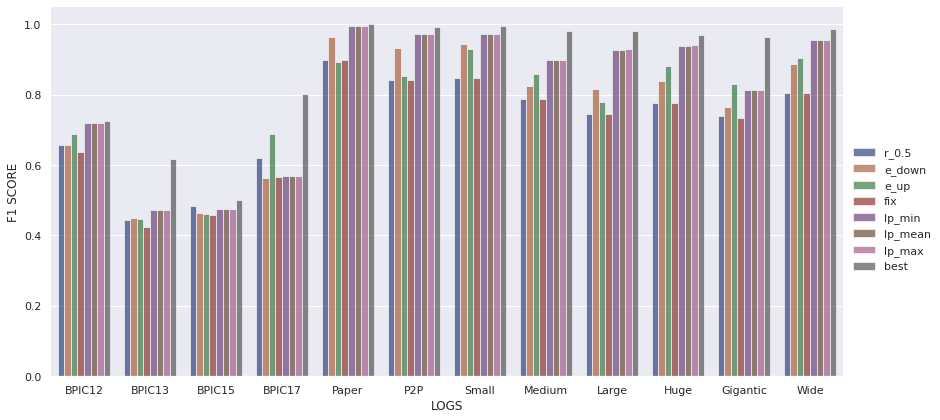

In [ ]:

g = sns.catplot(
    data=plot_data, kind="bar",
    x="Log", y="F1 Score", hue="Heuristic",
    ci="sd", palette="dark", alpha=.6, height=6,aspect=2
)
g.despine(left=True)
g.set_axis_labels("LOGS", "F1 SCORE")
plt.xticks(rotation = 0)
g.legend.set_title("")

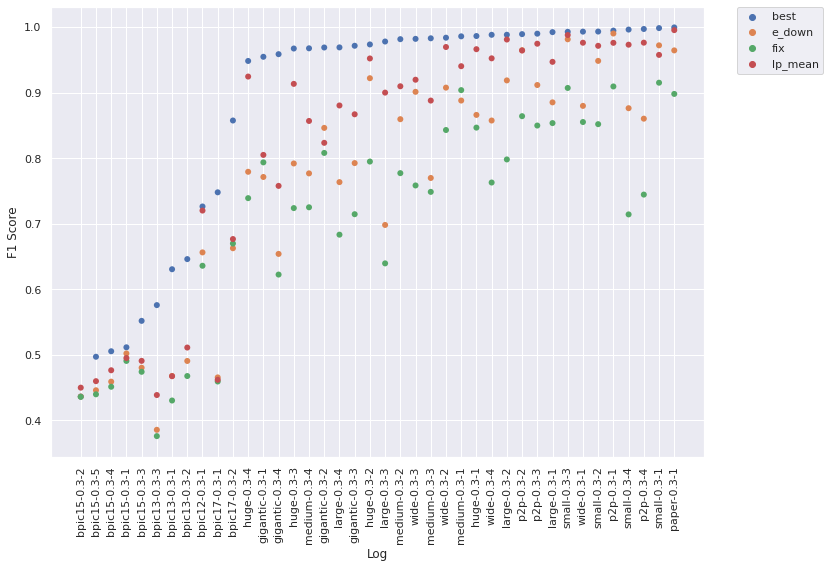

In [ ]:
binet_synth_df =heuristic_th_df.sort_values('best')

def get_plot_data(th_df,id_vars=['Log Name'],value_vars = ['F1 Score','Anomaly Ratio']):
    plot_data=th_df.melt(var_name='Heuristic',value_name='Score',id_vars =id_vars ,value_vars=value_vars,ignore_index=False)
    plot_data['Threshold']=plot_data.index
    plot_data.index=range(len(plot_data))
    return plot_data

plot_data = get_plot_data(binet_synth_df,id_vars=['Log'],value_vars=['best',
 'e_down',
 'fix',
 'lp_mean',
])


log2int = {j:i for i,j in enumerate(binet_synth_df['Log'].unique())}
plot_data ['Log']= plot_data['Log'].map(log2int)
plot_data ['F1 Score']=plot_data ['Score']

sns.set(rc={'figure.figsize':(11.7,8.27)})

g=sns.scatterplot(data =plot_data, x='Log',y='F1 Score', hue='Heuristic' ,linewidth=0,)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_xticks(range(len(binet_synth_df)));
g.set_xticklabels(binet_synth_df['Log'].unique(),rotation = 90);


## Anomaly Types

In [ ]:
h_ths_df['lp_mean']

activity    0.988
user        0.983
day         0.986
country     0.980
company     0.980
Name: lp_mean, dtype: float64

In [ ]:
log_name = 'large-0.3-4'
score_df,cols,o = get_score_df(log_name)
max_error_cases = score_df.groupby('trace_id').max()
y_true =o.items.groupby(o.items.index)['anomaly'].last().to_numpy() != 'normal'
df =threshold_anomaly_ratio_df_fixed(max_error_cases)
h_ths = {col:[i for j in [[k.Th for k in listify(h(df[df['Col']==col]))] for h in heuristics] for i in j] for col in cols}
h_ths_df = pd.DataFrame(h_ths,index=heuristic_names).transpose()
ths = h_ths_df['lp_mean']
y_pred =(np.array([(max_error_cases[c]>ths[c]).tolist() for c in cols]).max(axis=0))   
k=o.items.groupby(o.items.index)['anomaly'].last().iloc[np.where(np.equal(y_pred, y_true))[0]]
k.value_counts()

normal          3111
Early            267
Insert           262
SkipSequence     258
Rework           251
Late             239
Attribute        209
Name: anomaly, dtype: int64

In [ ]:
k=o.items.groupby(o.items.index)['anomaly'].last().iloc[np.where(~np.equal(y_pred, y_true))[0]]
k.value_counts()
multi_attr_f1_score(y_true,max_error_cases,ths.to_dict())

0.8805925925925925

In [ ]:
ths

activity    0.986
user        0.973
day         0.966
country     0.983
company     0.978
Name: lp_mean, dtype: float64

In [ ]:
log_name

'bpic15-0.3-4'

In [ ]:
best_th_df

,log_name,best F1 Score,activity,user,day,country,company,org:resource
0,bpic15-0.3-4,0.505628,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
1,large-0.3-4,0.969201,0.926509,0.993697,0.991158,0.996668,0.998505,0.000000
2,small-0.3-4,0.996392,0.827836,0.990407,0.996365,0.978193,0.984546,0.000000
3,bpic13-0.3-3,0.576037,0.828376,0.000000,0.000000,0.000000,0.000000,1.000000
4,medium-0.3-3,0.983084,0.853375,0.994926,0.989199,0.996987,0.000000,0.000000
5,medium-0.3-1,0.986074,0.922664,0.979162,0.000000,0.000000,0.000000,0.000000
6,bpic17-0.3-1,0.748115,0.988349,0.000000,0.000000,0.000000,0.000000,0.999921
7,wide-0.3-3,0.982225,0.967521,0.991711,0.991390,0.997332,0.000000,0.000000
8,large-0.3-2,0.988482,0.943651,0.993239,0.994222,0.000000,0.000000,0.000000
9,bpic17-0.3-2,0.857663,0.893300,0.000000,0.000000,0.000000,0.000000,0.998656


In [ ]:
logs = res_df['log_name'].tolist()
anomalie_types = []

for log_name in progress_bar(logs):
    score_df,cols,o = get_score_df(log_name)
    max_error_cases = score_df.groupby('trace_id').max()
    y_true =o.items.groupby(o.items.index)['anomaly'].last().to_numpy() != 'normal'
    df =threshold_anomaly_ratio_df_fixed(max_error_cases)
    h_ths = {col:[i for j in [[k.Th for k in listify(h(df[df['Col']==col]))] for h in heuristics] for i in j] for col in cols}
    h_ths_df = pd.DataFrame(h_ths,index=heuristic_names).transpose()
    for hn in heuristic_names:
        ths =h_ths_df[hn]
        y_pred =(np.array([(max_error_cases[c]>ths[c]).tolist() for c in cols if c in all_cols]).max(axis=0))   
        k=o.items.groupby(o.items.index)['anomaly'].last().iloc[np.where(np.equal(y_pred, y_true))[0]]
        k= k.value_counts().to_dict()
        k['heuristic']=hn
        k['log_name'] = log_name
        k['correct']=True
        anomalie_types.append(k)
        k=o.items.groupby(o.items.index)['anomaly'].last().iloc[np.where(~np.equal(y_pred, y_true))[0]]
        k= k.value_counts().to_dict()
        k['log_name'] = log_name
        k['correct']=False
        k['heuristic']=hn
        anomalie_types.append(k)
    settings = best_th_df[best_th_df['log_name']==log_name].iloc[0][2:]
    y_pred =(np.array([(max_error_cases[c]>settings[c]).tolist() for c in cols if c in all_cols]).max(axis=0))  
    k=o.items.groupby(o.items.index)['anomaly'].last().iloc[np.where(np.equal(y_pred, y_true))[0]]
    k= k.value_counts().to_dict()
    k['heuristic']='best'
    k['log_name'] = log_name
    k['correct']=True
    anomalie_types.append(k)
    k=o.items.groupby(o.items.index)['anomaly'].last().iloc[np.where(~np.equal(y_pred, y_true))[0]]
    k= k.value_counts().to_dict()
    k['log_name'] = log_name
    k['correct']=False
    k['heuristic']='best'
    anomalie_types.append(k)


In [ ]:
anomalie_types= pd.DataFrame(anomalie_types)
anomalie_types.fillna(0,inplace=True)

In [ ]:
1- (anomalie_types[(anomalie_types['heuristic']=='lp_mean')&(anomalie_types['correct']==False)]['Early'].sum() / 
anomalie_types[(anomalie_types['heuristic']=='lp_mean')]['Early'].sum())

0.8358172687510125

In [ ]:
anomalie_types[(anomalie_types['heuristic']=='lp_mean')]['Early'].sum()

12346.0

In [ ]:
anomalie_types= pd.DataFrame(anomalie_types)
anomalie_types.fillna(0,inplace=True)
pd.set_option('display.max_rows', None)



,normal,Attribute,Insert,Rework,Late,SkipSequence,Early,heuristic,log_name,correct
0,287.0,51.0,47.0,45.0,43.0,34.0,30.0,r_0.5,bpic15-0.3-4,True
1,459.0,4.0,0.0,15.0,14.0,14.0,10.0,r_0.5,bpic15-0.3-4,False
2,178.0,54.0,47.0,57.0,53.0,41.0,39.0,e_down,bpic15-0.3-4,True
3,568.0,1.0,0.0,3.0,4.0,7.0,1.0,e_down,bpic15-0.3-4,False
4,188.0,53.0,47.0,51.0,46.0,40.0,36.0,e_up,bpic15-0.3-4,True
5,558.0,2.0,0.0,9.0,11.0,8.0,4.0,e_up,bpic15-0.3-4,False
6,0.0,55.0,47.0,60.0,57.0,48.0,40.0,fix,bpic15-0.3-4,True
7,746.0,0.0,0.0,0.0,0.0,0.0,0.0,fix,bpic15-0.3-4,False
8,166.0,54.0,47.0,56.0,53.0,41.0,39.0,lp_min,bpic15-0.3-4,True
9,580.0,1.0,0.0,4.0,4.0,7.0,1.0,lp_min,bpic15-0.3-4,False


In [ ]:
anomalie_types_bpi = anomalie_types[anomalie_types['log_name'].str.contains('bpi')]
anomalie_types_synth = anomalie_types[~anomalie_types['log_name'].str.contains('bpi')]


In [ ]:
heuristics_desc = ['Best','Elbow↓','Elbow↑','Fix-98','LP-Max','LP-Mean','LP-Min','AR-0.5']


In [ ]:
anomalie_types = anomalie_types_bpi
anomalie_types_ratio =(anomalie_types[anomalie_types['correct']==False].groupby(['heuristic'])[anomalie_types.columns[:-3]].sum()
/ anomalie_types.groupby(['heuristic'])[anomalie_types.columns[:-3]].sum())
anomalie_types_ratio = 1 - (anomalie_types_ratio)

anomalie_types_ratio['Heuristic']=anomalie_types_ratio.index
anomalie_types_ratio['Normal']=anomalie_types_ratio['normal']
anomalie_types_ratio['Heuristic'] = heuristics_desc
anomalie_types_ratio

,normal,Attribute,Insert,Rework,Late,SkipSequence,Early,Heuristic,Normal
heuristic,,,,,,,,,
best,0.835520,0.572412,0.975619,0.897236,0.889665,0.856565,0.904296,Best,0.835520
e_down,0.402463,0.878898,1.000000,0.977034,0.861333,0.966115,0.841197,Elbow↓,0.402463
e_up,0.600269,0.761048,1.000000,0.939665,0.948125,0.943011,0.949175,Elbow↑,0.600269
fix,0.327712,0.912952,1.000000,0.994161,0.992817,0.994032,0.994630,Fix-98,0.327712
lp_max,0.477783,0.851731,0.999232,0.888283,0.732442,0.949557,0.745301,LP-Max,0.477783
lp_mean,0.476216,0.851731,0.999232,0.892371,0.733440,0.949750,0.746068,LP-Mean,0.476216
lp_min,0.475120,0.851923,0.999232,0.893149,0.734238,0.949942,0.746644,LP-Min,0.475120
r_0.5,0.531967,0.874689,1.000000,0.969638,0.958899,0.955141,0.962025,AR-0.5,0.531967


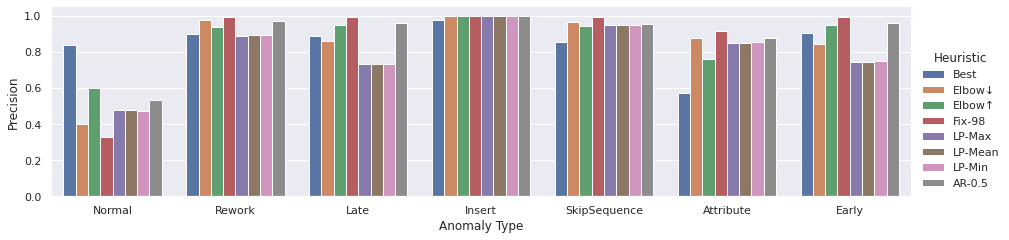

In [ ]:
color_palette = sns.color_palette()
df = anomalie_types_ratio.melt(var_name='Anomaly Type',value_name='Precision',id_vars ='Heuristic',value_vars=['Normal',
 'Rework',
 'Late',
 'Insert',
 'SkipSequence',
 'Attribute',
 'Early'],ignore_index=False)
g = sns.catplot(x="Anomaly Type", y="Precision",palette=color_palette,
                data=df, kind="bar",hue='Heuristic',
 height=3.5, aspect=3.7);


In [ ]:
anomalie_types = anomalie_types_synth
anomalie_types_ratio =(anomalie_types[anomalie_types['correct']==False].groupby(['heuristic'])[anomalie_types.columns[:-3]].sum()
/ anomalie_types.groupby(['heuristic'])[anomalie_types.columns[:-3]].sum())
anomalie_types_ratio = 1 - (anomalie_types_ratio)

anomalie_types_ratio['Heuristic']=anomalie_types_ratio.index
anomalie_types_ratio['Normal']=anomalie_types_ratio['normal']
anomalie_types_ratio['Heuristic'] = heuristics_desc
anomalie_types_ratio

,normal,Attribute,Insert,Rework,Late,SkipSequence,Early,Heuristic,Normal
heuristic,,,,,,,,,
best,0.990852,0.914103,1.0,0.999859,0.999587,0.997798,0.999720,Best,0.990852
e_down,0.872061,0.977029,1.0,0.999577,0.921563,0.982659,0.935923,Elbow↓,0.872061
e_up,0.879195,0.942225,1.0,0.981957,0.950323,0.930223,0.966209,Elbow↑,0.879195
fix,0.770102,0.987053,1.0,1.000000,1.000000,1.000000,1.000000,Fix-98,0.770102
lp_max,0.960989,0.960045,1.0,0.986186,0.878629,0.928571,0.901290,LP-Max,0.960989
lp_mean,0.960773,0.960184,1.0,0.986186,0.878767,0.929260,0.901430,LP-Mean,0.960773
lp_min,0.960655,0.960184,1.0,0.986186,0.878767,0.929810,0.901430,LP-Min,0.960655
r_0.5,0.771714,0.986914,1.0,1.000000,1.000000,1.000000,1.000000,AR-0.5,0.771714


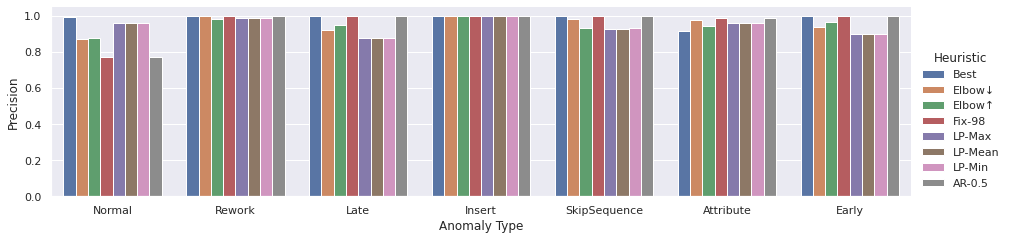

In [ ]:
color_palette = sns.color_palette()
df = anomalie_types_ratio.melt(var_name='Anomaly Type',value_name='Precision',id_vars ='Heuristic',value_vars=['Normal',
 'Rework',
 'Late',
 'Insert',
 'SkipSequence',
 'Attribute',
 'Early'],ignore_index=False)
g = sns.catplot(x="Anomaly Type", y="Precision",palette=color_palette,
                data=df, kind="bar",hue='Heuristic',
                height=3.5, aspect=3.7);
